# Lab Report: Revenue Management for Trojan Airlines

## 1. Executive Summary

Based on a simulation analysis, we find that the capacity rationing policy obtains the highest expected profit, with the best rationing policy obtaining an approximtaely 46\% improvement over the best constant price policy. The optimal parameters for the three policies and the corresponding profits are as follows.

| Policy | Expected Profit | Price 1 | Price 2 | Number of Seats Left |
|--|--|--|--|--|
|Constant Price | 2670 | 255 | - | - |
|Dynamic Price | 3553 | 240 | 305 | - |
|Capacity Rationing | 3888 | 230 | 320 | 41 |

For grading, a correct answer needs to have the following:

- Capacity rationing policy is the best.
- Best constant price between 240 and 270, and profit between 2300 and 3000.
- Best dynamic $p_1$ between 225 and 255, best $p_2$ between 290 and 335, and best profit between 3200 and 3900.
- Best rationing $p_1$ between 215 and 245, best $p_2$ between 305 and 340, best $l$ between 30 and 50, and best profit between 3500 and 4300.

## 2. Generating Customers

The following function creates customer data for one flight. It first generates the size of each segment, and then generate customer arrival time (time of purchase given as days before departure) and willingness to pay for each segment, according to the generated size. It stores the result in a DataFrame, which is sorted by the arrival time according to who came first.

In [1]:
from scipy.stats import uniform, norm
import pandas as pd
def generateCustomers():
    leisureSize=max(0,int(round(norm(200,60).rvs())))
    businessSize=max(0,int(round(norm(60,20).rvs())))
    leisureTime=uniform(0,180)
    businessTime=uniform(0,14)
    leisureValue=norm(200,80)
    businessValue=norm(350,120)
    data=[]
    for i in range(leisureSize):
        data.append([leisureTime.rvs(),leisureValue.rvs()])
    for i in range(businessSize):
        data.append([businessTime.rvs(),businessValue.rvs()])
    customers=pd.DataFrame(data,columns=['arrival_time','valuation'])
    customers=customers.sort_values(by='arrival_time',ascending=False)
    customers.index=range(len(customers))
    return customers

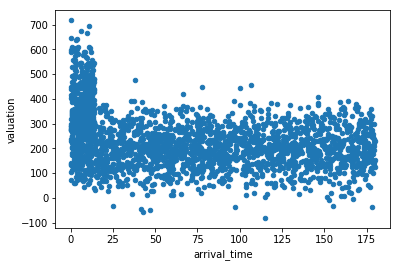

In [26]:
# Test code for grading
import numpy as np
np.random.seed(0)
pd.concat([generateCustomers() for i in range(10)])\
    .plot(x='arrival_time',y='valuation',kind='scatter')

## 3. Simulating Pricing Policies

The following code cell defines three function for the three pricing policies. Each function calculates the total revenue given the customer information and the parameters of the pricing policy.

In [52]:
def simulateConstant(customers,seats,p):
    ''' Returns the revenue earned from charging a constant price of p,
    given a specified number of total seats.'''
    return min(seats,(customers['valuation']>=p).sum())*p

def simulateDynamic(customers,seats,p1,p2):
    ''' Returns the revenue earned from charging price p1 up to 14 days
    before departure, and then changing the price to p2. The total number
    of seats is given as an input parameter, as well as the customer arrival
    times and valuations (in the customers DataFrame).'''
    revenue=0
    p=p1
    for i in customers.index:
        if seats==0:
            break
        if customers.loc[i,'arrival_time']<=14:
            p=p2
        if customers.loc[i,'valuation']>=p:
            revenue+=p
            seats-=1
    return revenue

def simulateRationing(customers, seats, p1, p2, l):
    '''Returns the revenue earned from charging a price of p1 until
    only l tickets are left, and then charging a price of p2. The total number
    of seats is given as an input, as well as the customer arrival times and
    valuations (in the customers DataFrame)'''
    revenue=0
    p=p1
    for i in customers.index:
        if seats==0:
            break
        if seats<=l:
            p=p2
        if customers.loc[i,'valuation']>=p:
            revenue+=p
            seats-=1
    return revenue   

In [53]:
# Test code for automatic grading 
import pandas as pd
import numpy as np

def testConstant():
    data=[[170,50],[150,40],[13,95],[12,100]]
    customers=pd.DataFrame(data,columns=['arrival_time','valuation'])
    if not simulateConstant(customers,2,50)==100:
        return False
    if not simulateConstant(customers,2,100)==100:
        return False
    data=[[170,50],[150,40],[14,40],[13,95],[12,100]]
    customers=pd.DataFrame(data,columns=['arrival_time','valuation'])
    if not simulateConstant(customers,1,40)==40:
        return False
    if not simulateConstant(customers,3,50)==150:
        return False
    if not simulateConstant(customers,5,40)==200:
        return False
    return True

def testDynamic():
    data=[[170,50],[150,40],[13,95],[12,100]]
    customers=pd.DataFrame(data,columns=['arrival_time','valuation'])
    if not simulateDynamic(customers,3,40,95)==175:
        return False
    if not simulateDynamic(customers,2,40,95)==80:
        return False
    if not simulateDynamic(customers,1,50,100)==50:
        return False
    data=[[170,50],[150,40],[13,95],[13.5,40],[12,100]]
    customers=pd.DataFrame(data,columns=['arrival_time','valuation'])
    if not simulateDynamic(customers,2,40,100)==80:
        return False
    if not simulateDynamic(customers,4,40,95)==270:
        return False
    return True

def testRationing():
    data=[[170,50],[150,40],[13,95],[12,100]]
    customers=pd.DataFrame(data,columns=['arrival_time','valuation'])
    if not simulateRationing(customers,3,40,100,1)==180:
        return False
    if not simulateRationing(customers,2,40,100,1)==140:
        return False
    if not simulateRationing(customers,1,40,95,1)==95:
        return False
    data=[[170,50],[150,40],[120,50],[13,95],[12,100],[11,150]]
    customers=pd.DataFrame(data,columns=['arrival_time','valuation'])
    if not simulateRationing(customers,3,40,100,0)==120:
        return False
    if not simulateRationing(customers,3,40,100,1)==180:
        return False
    if not simulateRationing(customers,3,40,100,2)==240:
        return False
    if not simulateRationing(customers,3,40,151,2)==40:
        return False
    if not simulateRationing(customers,3,40,100,3)==200:
        return False
    return True

def testAll():
    correct='1 (CORRECT)'
    wrong='0 (WRONG)'
    error='0 (RUNTIME ERROR, CHECK BY HAND USING BELOW CODE)'
    try:
        if testConstant():
            constant=correct
        else:
            constant=wrong
    except:
        constant=error
    try:
        if testDynamic():
            dynamic=correct
        else:
            dynamic=wrong
    except:
        dynamic=error
    try:
        if testRationing():
            rationing=correct
        else:
            rationing=wrong
    except:
        rationing=error
    print('Test results')
    print('\tsimulateConstant:\t',constant,'\n')
    print('\tsimulateDynamic:\t',dynamic,'\n')
    print('\tsimulateRationing:\t',rationing,'\n')
    
testAll()
        

Test results
	simulateConstant:	 1 (CORRECT) 

	simulateDynamic:	 1 (CORRECT) 

	simulateRationing:	 1 (CORRECT) 



## 4. Optimizing Parameters

The following code first generates a list of 100 randomly generated DataFrames, each containing customer 

### 4.1 Generating 100 Sets of Simulated Customer Data

In [6]:
# Generating a list of 1000 customer scenarios (like 1000 random flights)
N=100
import numpy as np
np.random.seed(0)
dataset=[generateCustomers() for i in range(N)]

### 4.2 Optimizing Constant Policy

In [21]:
import numpy as np
seats=100
fixedCost=20000
resultsConstant=pd.DataFrame()
i=0
for p in range(0,750,5):
    revenue=np.average([simulateConstant(customers,seats,p) \
                        for customers in dataset])
    profit=revenue-fixedCost
    resultsConstant.loc[i,'Price']=p
    resultsConstant.loc[i,'Profit']=profit
    i+=1
resultsConstant.sort_values(by='Profit',ascending=False).head(1)

,Price,Profit
51,255.0,2669.5


### 4.2 Optimizing Dynamic Policy

In [9]:
# Take 1 with high jumps
import numpy as np
seats=100
fixedCost=20000
resultsDynamic=pd.DataFrame()
i=0
for p1 in range(0,750,50):
    for p2 in range(0,750,50):
        revenue=np.average([simulateDynamic(customers,seats,p1,p2)\
                            for customers in dataset])
        profit=revenue-fixedCost
        resultsDynamic.loc[i,'Price1']=p1
        resultsDynamic.loc[i,'Price2']=p2
        resultsDynamic.loc[i,'Profit']=profit
        i+=1
resultsDynamic.sort_values(by='Profit',ascending=False).head(10).agg(['max','min'])

,Price1,Price2,Profit
max,250.0,400.0,3359.5
min,200.0,200.0,-266.0


In [10]:
# Take 2 with reduced bounds
import numpy as np
seats=100
fixedCost=20000
resultsDynamic2=pd.DataFrame()
i=0
for p1 in range(180,400,5):
    for p2 in range(180,400,5):
        revenue=np.average([simulateDynamic(customers,seats,p1,p2)\
                            for customers in dataset])
        profit=revenue-fixedCost
        resultsDynamic2.loc[i,'Price1']=p1
        resultsDynamic2.loc[i,'Price2']=p2
        resultsDynamic2.loc[i,'Profit']=profit
        i+=1
resultsDynamic2.sort_values(by='Profit',ascending=False)\
    .head(20).agg(['max','min'])

,Price1,Price2,Profit
max,245.0,330.0,3552.8
min,235.0,290.0,3447.5


In [13]:
resultsDynamic2.sort_values(by='Profit',ascending=False).head(1)

,Price1,Price2,Profit
553,240.0,305.0,3552.8


### 4.3 Optimizing Rationing Policy

In [11]:
# Take 1
import numpy as np
seats=100
resultsRationing=pd.DataFrame()
i=0
for p1 in range(0,750,50):
    for p2 in range(0,750,50):
        for l in range(0,101,10):
            revenue=np.average(\
                    [simulateRationing(customers,seats,p1,p2,l)\
                     for customers in dataset])
            profit=revenue-fixedCost
            resultsRationing.loc[i,'Price1']=p1
            resultsRationing.loc[i,'Price2']=p2
            resultsRationing.loc[i,'Seats Left']=l
            resultsRationing.loc[i,'Profit']=profit
            i+=1
resultsRationing.sort_values(by='Profit',ascending=False)\
            .head(20).agg(['max','min'])

,Price1,Price2,Seats Left,Profit
max,250.0,400.0,100.0,3409.0
min,0.0,0.0,0.0,2620.0


In [15]:
resultsRationing.sort_values(by='Profit',ascending=False)\
            .head(10).agg(['max','min'])

,Price1,Price2,Seats Left,Profit
max,250.0,400.0,60.0,3409.0
min,200.0,300.0,10.0,3012.0


In [27]:
# Take 2 with reduced bounds
import numpy as np
seats=100
resultsRationing2=pd.DataFrame()
i=0
for p1 in range(190,270,5):
    for p2 in range(270,430,5):
        for l in range(0,101,1):
            revenue=np.average([simulateRationing(customers,seats,p1,p2,l) \
                                for customers in dataset])
            profit=revenue-fixedCost
            resultsRationing2.loc[i,'Price1']=p1
            resultsRationing2.loc[i,'Price2']=p2
            resultsRationing2.loc[i,'Seats Left']=l
            resultsRationing2.loc[i,'Profit']=profit
            i+=1
resultsRationing2.sort_values(by='Profit',ascending=False)\
                .head(10).agg(['max','min'])

,Price1,Price2,Seats Left,Profit
max,235.0,330.0,42.0,3887.7
min,230.0,315.0,35.0,3868.0


In [30]:
resultsRationing2.sort_values(by='Profit',ascending=False)\
                .head(60).agg(['max','min'])

,Price1,Price2,Seats Left,Profit
max,235.0,340.0,45.0,3887.7
min,230.0,305.0,32.0,3842.6


In [14]:
resultsRationing2.sort_values(by='Profit',ascending=False).head(1)

,Price1,Price2,Seats Left,Profit
9131,230.0,320.0,41.0,3887.7


In [17]:
# Percentage improvement
resultsRationing2['Profit'].max()/resultsConstant['Profit'].max()-1

0.4563401386027348